# Lab 2.3: Graph-Time Convolutional Neural Networks

In this lab you will learn how to implement a graph-time convolutional neural network (GTCNN).
The specific objectives are:

*   Generating dataset from time-series over networks.
*   Creating different types of product graphs.
*   Study the performance of GTCNN and comparing it with a baseline GCNN.

**Completion requirements:**
* Build a product graph and visualize the sparisty.
* Train and test a GTCNN for different product graphs.
* Train and test a regular GCNN that considers time stamps as features.



# Dataset and problem definition

To achieve the abovementioned objectives, we will use a real-world weather dataset **NOAA**.
The dataset contains hourly temperature measurements for a year in the US over 109 different weather stations.
We will use GTCNN to forecast future values over all the nodes based on an observation window and a the structure of the network.
$$
\textbf{x}_{t+h} = \phi(\textbf{x}_{t-T+1}:\textbf{x}_t,\textbf{S}),
$$
where $h$ is the forecasting horizon, $w$ is the observation window, and $\textbf{S}$ is the shift operator of the graph.
The goal is to learn the funtion $\phi(\cdot)$ using GTCNN model and evaluate the result.

## Libraries

* Numpy
* Matplotlib
* PyGSP or NetworkX (graph-related library of your own choice)
* Matplotlib
* Pandas
* Torch

In [1]:
import numpy as np
from pygsp import graphs, plotting
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

# Creating a dataset

We need to extract a dataset out of the raw data for training, validation, and testing of the model. 

In [2]:
timeseries_data = np.load(file='lab2_NOAA/NOA_109_data.npy')
print(f"The dataset contains {timeseries_data.shape[1]} measurements over {timeseries_data.shape[0]} stations.")

The dataset contains 8759 measurements over 109 stations.


Generate a dataset with the splits of your own choice for observation window $T = 4$ and forecasting horizon $h = 1$.
Print the number of samples in each partition.

In [3]:
split = [0.5, 0.25, 0.25] # [.3, .2, .5]; train, validation, test portions -- summed up to 1
pred_horizen = 1
obs_window = 4
n_stations = timeseries_data.shape[0]
n_timestamps = timeseries_data.shape[1]

In [4]:
from GTCNN.components.train_utils import create_forecasting_dataset

dataset = create_forecasting_dataset(timeseries_data,
                                     splits = split,
                                     pred_horizen= pred_horizen,
                                     obs_window= obs_window,
                                     in_sample_mean= False)

dataset has been created.
-------------------------
4375 train data points
2186 validation data points
2186 test data points


## Question 1

Calculate the mean value over network in each time stamp and plot the distribution of it for each partition in a specific station.
What can you conclude? 

In [5]:
print(timeseries_data.shape)
print(dataset.keys())
print(dataset['trn'].keys())
print(dataset['trn']['data'].shape)
print(dataset['trn']['labels'].shape)

(109, 8759)
dict_keys(['trn', 'val', 'tst'])
dict_keys(['data', 'labels'])
(4375, 109, 4)
(4375, 109, 1)


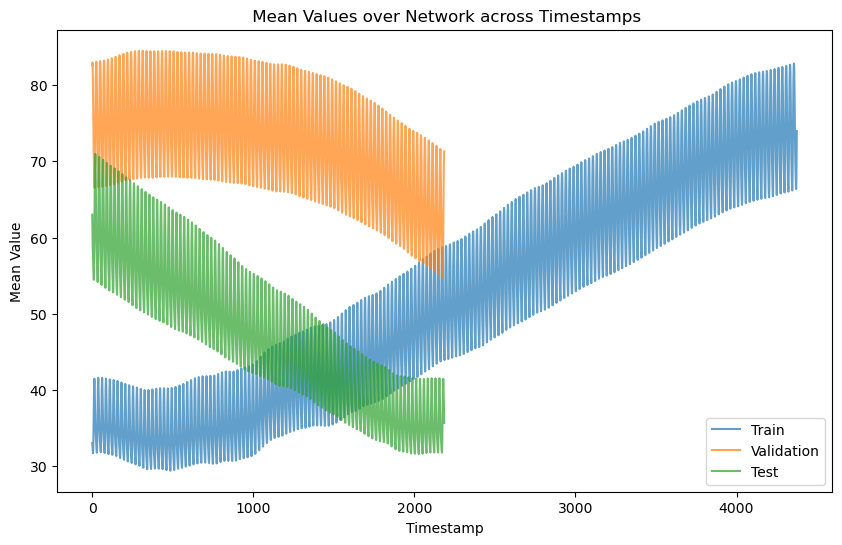

In [6]:
# Calculate the mean value over the network in each time stamp

trn_mean_list = []
val_mean_list = []
tst_mean_list = []

for timestamp in range (0, dataset['trn']['data'].shape[0]):
    trn_mean = np.mean(dataset['trn']['data'][timestamp, :, :], axis=1)
    trn_mean_list.append(trn_mean) 

for timestamp in range (0, dataset['val']['data'].shape[0]):
    val_mean = np.mean(dataset['val']['data'][timestamp, :, :], axis=1)
    val_mean_list.append(val_mean)

for timestamp in range (0, dataset['tst']['data'].shape[0]):
    tst_mean = np.mean(dataset['tst']['data'][timestamp, :, :], axis=1)
    tst_mean_list.append(tst_mean)   

trn_mean_network = [np.mean(trn_mean_list[i]) for i in range(len(trn_mean_list))]
val_mean_network = [np.mean(val_mean_list[i]) for i in range(len(val_mean_list))]
tst_mean_network = [np.mean(tst_mean_list[i]) for i in range(len(tst_mean_list))]

# Plot the distribution of mean values for each partition
plt.figure(figsize=(10, 6))
plt.plot(trn_mean_network, label='Train', alpha=0.7)
plt.plot(val_mean_network, label='Validation', alpha=0.7)
plt.plot(tst_mean_network, label='Test', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Mean Value')
plt.title(f' Mean Values over Network across Timestamps')
plt.legend()
plt.show()

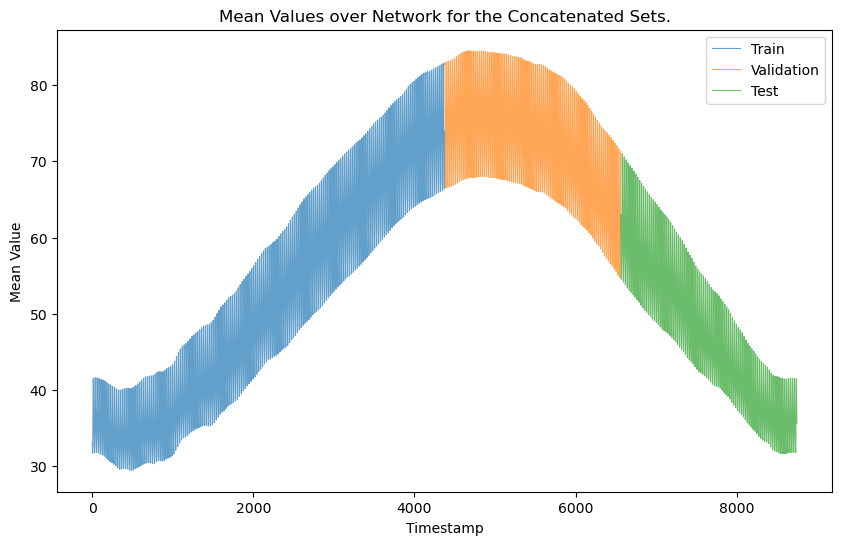

In [7]:
plt.figure(figsize=(10, 6))

# Plot train set
trn_len = len(trn_mean_network)
plt.plot(range(trn_len), trn_mean_network, label='Train', color='#1f77b4', alpha=0.7, linewidth=0.8)

# Plot validation set
val_start = trn_len
val_len = len(val_mean_network)
plt.plot(range(val_start, val_start+val_len), val_mean_network, label='Validation', color='#ff7f0e', alpha=0.7, linewidth=0.8)

# Plot test set
test_start = val_start + val_len
test_len = len(tst_mean_network)
plt.plot(range(test_start, test_start+test_len), tst_mean_network, label='Test', color='#2ca02c', alpha=0.7, linewidth=0.8)

plt.xlabel('Timestamp')
plt.ylabel('Mean Value')
plt.title('Mean Values over Network for the Concatenated Sets.')
plt.legend()
plt.show()


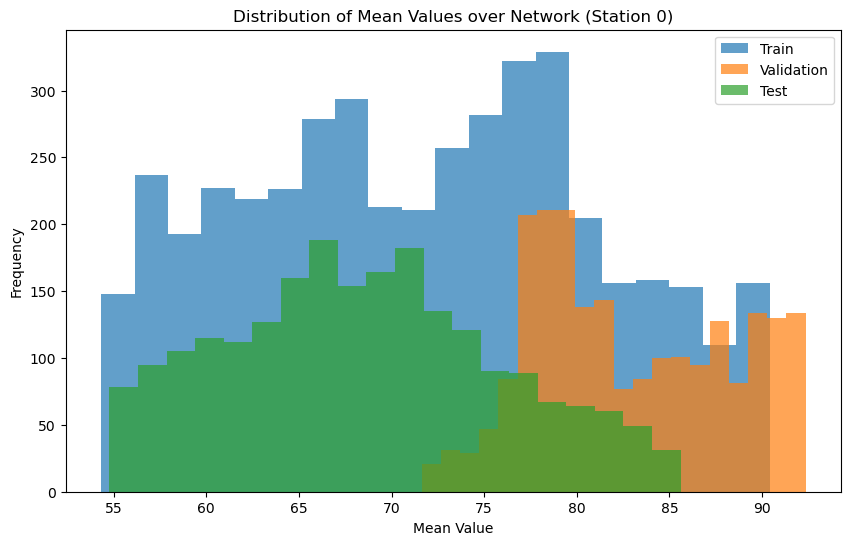

In [8]:
# Calculate the mean value over the network for a specific station

station_idx = 0  

trn_mean = np.mean(dataset['trn']['data'][:, station_idx, :], axis=1)
val_mean = np.mean(dataset['val']['data'][:, station_idx, :], axis=1)
tst_mean = np.mean(dataset['tst']['data'][:, station_idx, :], axis=1)

# Plot the distribution of mean values for each partition
plt.figure(figsize=(10, 6))
plt.hist(trn_mean, bins=20, label='Train', alpha=0.7)
plt.hist(val_mean, bins=20, label='Validation', alpha=0.7)
plt.hist(tst_mean, bins=20, label='Test', alpha=0.7)
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title(f'Distribution of Mean Values over Network (Station {station_idx})')
plt.legend()
plt.show()



**Answer**:

<font color = "red">
Looking at the plots, it becomes evident that the temporal sampling employed to partition the dataset into training, validation, and testing sets was not performed randomly. Instead, it was carried out by dividing the data into consecutive time periods. This approach is logical since random division would lead the network to rely on neighboring points to predict temperature values. <br></br>

The first graph I plotted shows the mean temperature value across the graph for each set as a function of the timestamp. It can be seen that the mean temperatures for each of the three sets behave differently as a function of time. The relation is clear in the second graph which shows the mean temperature of all network nodes varying across the year. Moreover, the high frequency oscillations represent the night and day temperature cycle. <br></br>

Finally, the last plot features a histogram showcasing the distribution of temperatures within each of the three sets. It is evident that the distributions differ depending on the time of the year the samples were collected from, resulting in variations of hotter or colder temperatures among the sets. The total number of samples in each set, resulting from adding the height of all bins, varies according to split previously mentioned. <br></br>



**Note:** The issue you are observing in these distributions can be addressed via backtesting. We do not discuss this in the Lab but you may consider it for your future projects on time series forecasting.

# Task 1: Creating product graph

First create a $k$-nearest neighbors graph for the weather stations based on the available metadata.
Visualize the graph and print the sparsity factor.

2023-06-04 19:08:56,909:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


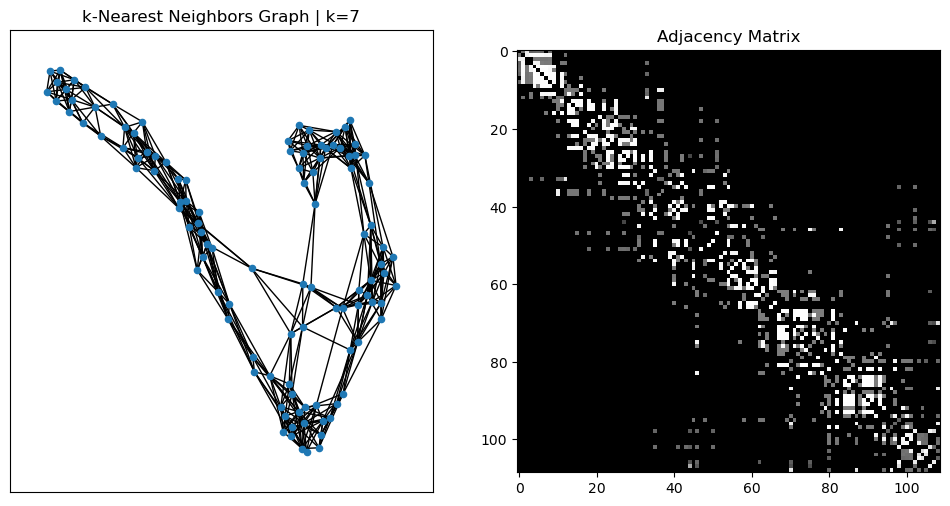

Sparsity factor: 0.9105


In [9]:
# Create k-Nearest Neighbors Graph
k = 7
graph = graphs.NNGraph(timeseries_data, k=k)
graph.W.setdiag(0)  
adjacency_matrix = graph.W.toarray()
edge_list = np.column_stack(np.where(adjacency_matrix > 0))
nx_graph = nx.Graph()
nx_graph.add_edges_from(edge_list)

# Calculate the sparsity factor
num_edges = np.sum(adjacency_matrix > 0)
num_nodes = graph.N
sparsity_factor = 1 - (num_edges / (num_nodes * (num_nodes - 1)))

# Visualize the graph
layout = nx.spring_layout(nx_graph, seed=42)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graph
ax1.set_title(f'k-Nearest Neighbors Graph | k={k}')
nx.draw_networkx(nx_graph, layout, with_labels=False, node_size=20, ax=ax1)

# Adjacency matrix
ax2.set_title('Adjacency Matrix')
ax2.imshow(adjacency_matrix, cmap='gray', origin='upper')

plt.show()

# Print the sparsity factor
print(f"Sparsity factor: {sparsity_factor:.4f}")


Create a temporal graph of your own choice and generate the Kronecker, Cartresian, and Strong product graphs. To generate a product graph $\textbf{S}_\diamond$, consider the parametric product graph expression and obtain Kronecker, Cartesian, and Strong product graphs by setting the parameters accordingly.
$$
\textbf{S}_\diamond = 
s_{00} \textbf{I}_T \otimes \textbf{I}_N +
s_{01} \textbf{I}_T \otimes \textbf{S} +
s_{10} \textbf{S}_T \otimes \textbf{I}_N +
s_{11} \textbf{S}_T \otimes \textbf{S} 
$$

Plot the adjacency matrices to visualize the structure and compute the sparsity factors for each of them.
Which graph is the sparsest and why?

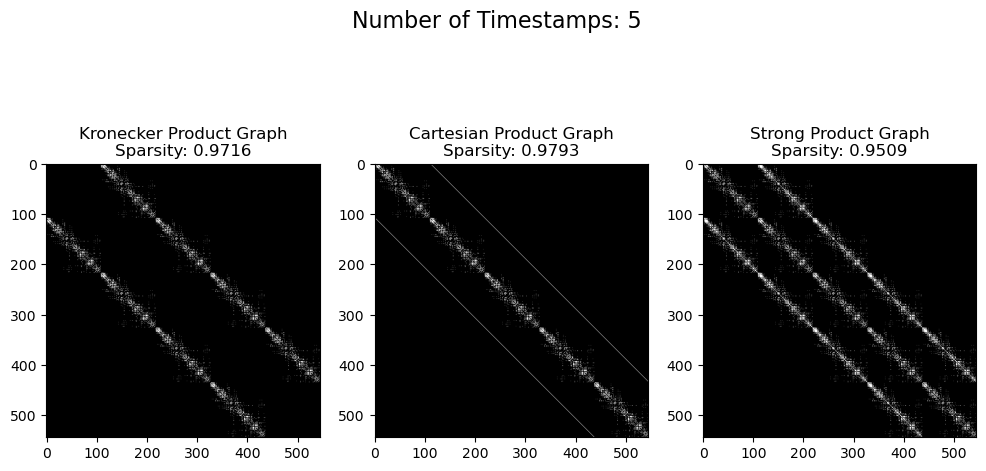

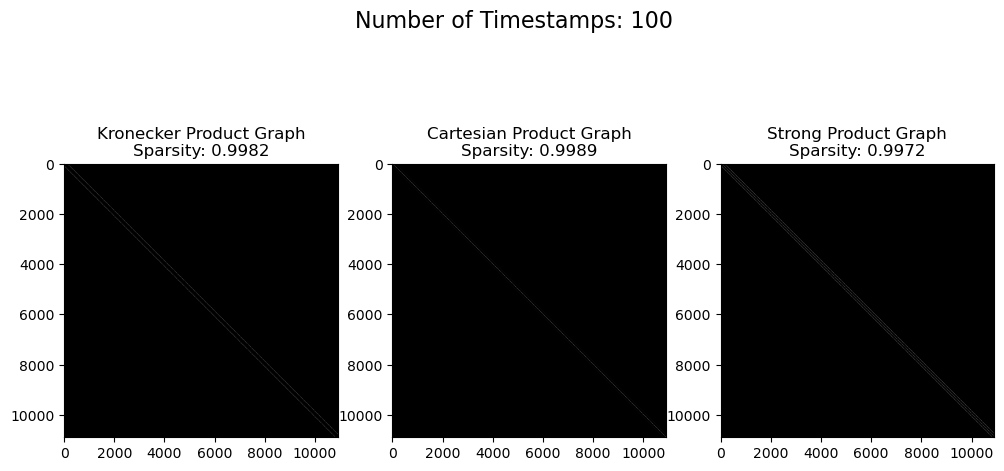

In [10]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

# Create the temporal graph adjacency matrix
S_T = np.eye(n_timestamps, k=1) + np.eye(n_timestamps, k=-1)

# Define the parameters for the product graphs
parameters = {
    'Kronecker': (0, 0, 0, 1),
    'Cartesian': (0, 1, 1, 0),
    'Strong': (0, 1, 1, 1)
}

# Define the n_timestamps_truncated values
n_timestamps_truncated_values = [5, 100]

for n_timestamps_truncated in n_timestamps_truncated_values:
    S_T_truncated = S_T[:n_timestamps_truncated, :n_timestamps_truncated]
    product_graphs = {}

    for product, (s00, s01, s10, s11) in parameters.items():
        # Compute the adjacency matrix of the product graph
        I_T = sp.eye(n_timestamps_truncated)
        I_N = sp.eye(n_stations)
        S = sp.csr_matrix(adjacency_matrix)
        S_T_sp = sp.csr_matrix(S_T_truncated)

        S_diamond = s00 * sp.kron(I_T, I_N) + s01 * sp.kron(I_T, S) + s10 * sp.kron(S_T_sp, I_N) + s11 * sp.kron(S_T_sp, S)

        # Store the adjacency matrix and the sparsity factor
        product_graphs[product] = {
            'adjacency_matrix': S_diamond,
            'sparsity_factor': 1 - (S_diamond.nnz / (n_timestamps_truncated * n_stations)**2)
        }

    # Plot the adjacency matrices
    fig, axes = plt.subplots(nrows=1, ncols=len(product_graphs), figsize=(12, 6))
    fig.suptitle(f"Number of Timestamps: {n_timestamps_truncated}", fontsize=16)  

    for i, (product, details) in enumerate(product_graphs.items()):
        axes[i].imshow(details['adjacency_matrix'].toarray(), cmap='gray')
        axes[i].set_title(f"{product} Product Graph\nSparsity: {details['sparsity_factor']:.4f}")
    plt.show()


In [11]:
# Chosen number of timestamps
n_timestamps_truncated = 10 # Above 100, I get memory errors
S_T_truncated = S_T[:n_timestamps_truncated, :n_timestamps_truncated]

product_graphs = {}

for product, (s00, s01, s10, s11) in parameters.items():
    # Compute the adjacency matrix of the product graph
    I_T = sp.eye(n_timestamps_truncated)
    I_N = sp.eye(n_stations)
    S = sp.csr_matrix(adjacency_matrix)
    S_T_sp = sp.csr_matrix(S_T_truncated)
    
    S_diamond = s00 * sp.kron(I_T, I_N) + s01 * sp.kron(I_T, S) + s10 * sp.kron(S_T_sp, I_N) + s11 * sp.kron(S_T_sp, S)

    # Store the adjacency matrix and the sparsity factor
    product_graphs[product] = {
        'adjacency_matrix': S_diamond,
        'sparsity_factor': 1 - (S_diamond.nnz / (n_timestamps_truncated * n_stations)**2)
    }


## Question 2

Plot the sparsity factor for all the product graphs and of the spatial graph sparsity as a function of $k$. On which graph the sparsity decreases faster?

In [12]:
## Calculate the sparsity factor here (# of zeros in S / number of all elements in S)

# Chosen number of timestamps
n_timestamps_truncated = 10 # Above 100, I get memory errors

# Sparsity factors for different k values
kronecker_sparsities = []
cartesian_sparsities = []
strong_sparsities = []
spatial_graph_sparsities = []

ks = range(1, 10)

# Loop over different k values
for k in ks:

    # Create k-Nearest Neighbors Graph
    graph = graphs.NNGraph(timeseries_data, k=k)
    graph.W.setdiag(0)  
    adjacency_matrix = graph.W.toarray()
    edge_list = np.column_stack(np.where(adjacency_matrix > 0))
    nx_graph = nx.Graph()
    nx_graph.add_edges_from(edge_list)

    # Calculate the spatial graph sparsity factor
    num_edges = np.sum(adjacency_matrix > 0)
    num_nodes = graph.N
    sparsity_factor = 1 - (num_edges / (num_nodes * (num_nodes - 1)))
    
    S_T_truncated = S_T[:n_timestamps_truncated, :n_timestamps_truncated]

    product_graphs = {}

    for product, (s00, s01, s10, s11) in parameters.items():
        # Compute the adjacency matrix of the product graph
        I_T = sp.eye(n_timestamps_truncated)
        I_N = sp.eye(n_stations)
        S = sp.csr_matrix(adjacency_matrix)
        S_T_sp = sp.csr_matrix(S_T_truncated)
        
        S_diamond = s00 * sp.kron(I_T, I_N) + s01 * sp.kron(I_T, S) + s10 * sp.kron(S_T_sp, I_N) + s11 * sp.kron(S_T_sp, S)

        # Store the adjacency matrix and the sparsity factor
        product_graphs[product] = {
            'adjacency_matrix': S_diamond,
            'sparsity_factor': 1 - (S_diamond.nnz / (n_timestamps_truncated * n_stations)**2)
        }

    # Store the sparsity factors
    kronecker_sparsities.append(product_graphs['Kronecker']['sparsity_factor'])
    cartesian_sparsities.append(product_graphs['Cartesian']['sparsity_factor'])
    strong_sparsities.append(product_graphs['Strong']['sparsity_factor'])
    spatial_graph_sparsities.append(sparsity_factor)

2023-06-04 19:09:06,517:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-06-04 19:09:06,795:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-06-04 19:09:07,162:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-06-04 19:09:07,440:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-06-04 19:09:07,719:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-06-04 19:09:07,996:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-06-04 19:09:08,292:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-06-04 19:09:08,571:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-06-04 19:09:08,852:[WARNING](pygsp.graphs.graph.che

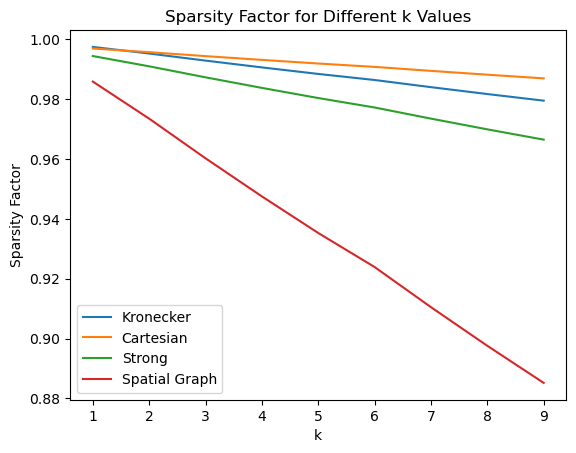

In [13]:
## Plot sparsity factors here
plt.plot(ks, kronecker_sparsities, label='Kronecker')
plt.plot(ks, cartesian_sparsities, label='Cartesian')
plt.plot(ks, strong_sparsities, label='Strong')
plt.plot(ks, spatial_graph_sparsities, label='Spatial Graph')
plt.xlabel('k')
plt.ylabel('Sparsity Factor')
plt.title('Sparsity Factor for Different k Values')
plt.legend()
plt.show()    

**Answer**:
<font color = 'red'>

A k increases, the sparsity decreases the fastest for the spatial graph. The reason for this is that the spatial graph is the only one that does not consider the temporal dimension. Therefore, the number of edges is only dependent on the number of neighbors considered. For the product graphs, the total number of edges is composed of both edges referring to the k-nearest neighbors and edges referring to the connections across timestamps. Therefore, as k increases, the sparsity decreases slower since only a fraction of the total nodes is increasing in number. <br></br>

Among the three product graphs, the sparsity decreases the fastest for the Strong graph, followed by Kronecker and lastly the Cartesian. Since the Cartesian product graph only links each node to itself across timestamps, it's temporal domain is not affected by the number of neighbors considered. The Kronecker product graph accounts for temporal coupling by linking nodes across the timestamps based on their spatial connectivity. Lastly the Strong graph combines the Cartesian and Kronecker approaches and sees the greatest reduction in sparsity factor as a function of K.  <br></br>

The current analysis is made by creating a temporal graph making use of n_timestamps_truncated = 10, for higher numbers of timestamps considered, the difference between the three product graph and the spatial graph is even more evident. The reason being that the fraction of nodes connecting timestamps over the total number of nodes is increased. <br></br>

# Task 2: GTCNN model design



In [14]:
import torch
import torch.nn as nn
from GTCNN.parametric_pooling_net import ParametricNetWithPooling
from GTCNN.components.evaluation import MSELossWithSparsityRegularizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from GTCNN.components.train_utils import train_model_regression

Create a GTCNN model which takes windowed time series as input $\textbf{X} \in \reals^{F \times N \times T}$, where $F$ is the number of features, $N$ is the number of nodes, and $T$ is the observation window.
The output should be a $h$-step ahead prediction (in this Lab $h=1$) of size $\hat{\textbf{y}} \in \reals ^ N$.
Compute the number of parameters for the designed model.

To obtain the output, you need to add a fully connected layer at the end of your model. This is needed to match the dimensions of the GTCNN embedding to the output.

In [57]:
## Design your model here
# you can use ParametricNetWithPooling provided to you
# you can also use pytorch geometry library.

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

n = len(adjacency_matrix)
model = ParametricNetWithPooling(
    window = obs_window,
    cyclic_time_graph = False,
    time_directed = True,
    S_spatial = adjacency_matrix,
    n_feat_per_layer=[1, 4, 8],
    n_taps_per_layer=[2, 2],
    n_active_nodes_per_timestep_per_layer=[num_nodes, int(109*0.6), int(109*0.9)],
    time_pooling_ratio_per_layer=[1, 4],
    pool_reach_per_layer=[1, 1],
    output_dim=109,
    device=device
)

Initialization (random) with gain 0.2
Initialization (random) with gain 0.2


In [58]:
## calculate the number of parameters here
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_parameters}")

Number of parameters: 66473


Train the GTCNN model for NOAA dataset. The loss function we use is a regularized MSE for parametric product graph, or just a MSE loss if you are using a fixed product graph.
$$
\mathcal{J} = \text{MSE}(\textbf{y},\hat{\textbf{y}}) + \gamma\|\textbf{s}\|_1,
$$
where $\textbf{y}$ is the label or true future value, $\hat{\textbf{y}}$ is the model prediction, $\textbf{s}$ is a vector of product graph parameters, and $\gamma$ is a regularization scalar.
The $l_1$-norm is used as regularizer for parametric product graph learnable parameters to sparsify the graph.
You need to reshape the dataset so the dimensions match your designed model. 

In [59]:
## Define your learning parameters here.

num_epochs = 30
batch_size = 32

weight_decay = 10e-5
patience = 10
learning_rate = 10e-4
factor = 0.9

loss_criterion = MSELossWithSparsityRegularizer(model=model, alpha=10e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=factor)
val_metric = None 

In [60]:
## prepare the data and reshape them to match the dimensions of your model

train_data = dataset['trn']['data'].reshape(-1, 1, 109, 4)
val_data = dataset['val']['data'].reshape(-1, 1, 109, 4)
test_data = dataset['tst']['data'].reshape(-1, 1, 109, 4)

train_labels = dataset['trn']['labels'].reshape(-1, 109)
val_labels = dataset['val']['labels'].reshape(-1, 109)
test_labels = dataset['tst']['labels'].reshape(-1, 109)


# Convert the data to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).to(device)

val_data_tensor = torch.tensor(val_data, dtype=torch.float32).to(device)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32).to(device)

test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).to(device)

In [61]:
## Train the model here
model, best_epoch, train_losses, validation_losses = train_model_regression(
    model=model,
    training_data=train_data_tensor,
    validation_data=val_data_tensor,
    single_step_trn_labels=train_labels_tensor,
    single_step_val_labels=val_labels_tensor,
    num_epochs=num_epochs,
    batch_size=batch_size,
    loss_criterion=loss_criterion,
    optimizer=optimizer, scheduler=scheduler,
    val_metric_criterion=val_metric,
    log_dir='./',
    not_learning_limit=20
)

136 batches per epoch (4375 trn samples in total | batch_size: 32)
Epoch 0
	 train-loss: 650.566 | valid-loss: 46.103 	| valid-metric: 46.103 | lr: 0.001

				New best val_metric: 46.103. Saving model...

Epoch 1
	 train-loss: 25.149 | valid-loss: 31.682 	| valid-metric: 31.682 | lr: 0.001

				New best val_metric: 31.682. Saving model...

Epoch 2
	 train-loss: 18.333 | valid-loss: 27.847 	| valid-metric: 27.847 | lr: 0.001

				New best val_metric: 27.847. Saving model...

Epoch 3
	 train-loss: 15.006 | valid-loss: 28.052 	| valid-metric: 28.052 | lr: 0.001
Epoch 4
	 train-loss: 12.797 | valid-loss: 19.548 	| valid-metric: 19.548 | lr: 0.001

				New best val_metric: 19.548. Saving model...

Epoch 5
	 train-loss: 10.876 | valid-loss: 19.169 	| valid-metric: 19.169 | lr: 0.001

				New best val_metric: 19.169. Saving model...

Epoch 6
	 train-loss: 9.281 | valid-loss: 15.259 	| valid-metric: 15.259 | lr: 0.001

				New best val_metric: 15.259. Saving model...

Epoch 7
	 train-loss: 7.8

Plot the train and validation loss per epoch. What do you conclude?

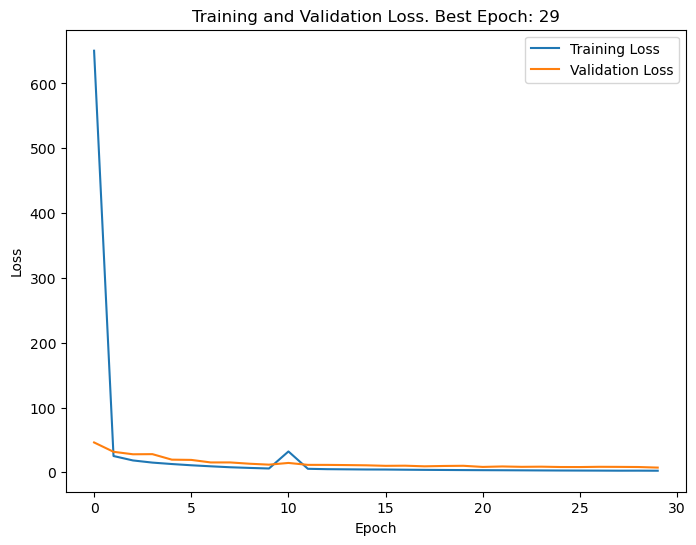

In [62]:
## plot here
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss. Best Epoch: {best_epoch}')
plt.legend()
plt.show()

**Answer**:
<font color = 'red'>


The model correctly trained and learned to predict the temperature values for the training set. Moreover, it generalized well to the validation set despite the different distributions shown previously. The validation loss stays always higher than the training loss, which is expected. <br></br>

# Task 3: GCNN
We will now treat the timeseries as different features over the graph nodes and use a regular GCNN to forecast.
You need to reshape the data here to set the length of time series (observation window) $T = 1$ and each time stamp should be a distinct feature in your input dataset. 

In [114]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader as pyg_DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from pygsp import graphs, plotting
import matplotlib.pyplot as plt

In [115]:
## reshape the dataset accordingly here
obs_window= 1

dataset = create_forecasting_dataset(timeseries_data,
                                     splits = split,
                                     pred_horizen= pred_horizen,
                                     obs_window= obs_window,
                                     in_sample_mean= False)

train_data = dataset['trn']['data']
val_data = dataset['val']['data']
test_data = dataset['tst']['data']

dataset has been created.
-------------------------
4378 train data points
2189 validation data points
2189 test data points


In [121]:
class GCNN(nn.Module):
    def __init__(self, node_dim, edge_dim, output_dim, hidden_dim, n_gnn_layers, dropout_rate):
        super(GCNN, self).__init__()

        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(node_dim, hidden_dim))
        

        for _ in range(n_gnn_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):

        x, edge_index = data.x, data.edge_index
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = nn.ReLU()(x)
            x = self.dropout(x)
        x = self.convs[-1](x, edge_index)

        return x

In [122]:
def train_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    criterion = torch.nn.MSELoss()

    for data in dataloader:
        
        data = data.to(device) 
        optimizer.zero_grad()

        # Forward pass
        out = model(data)
        loss = criterion(out, data.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate_epoch(model, dataloader):
    model.eval()
    total_loss = 0
    criterion = torch.nn.MSELoss()

    with torch.no_grad():
        for data in dataloader:
            data = data.to(device) 

            # Forward pass
            out = model(data)
            loss = criterion(out, data.y)

            total_loss += loss.item()

    return total_loss / len(dataloader)




In [123]:
input_dim = dataset['trn']['data'].shape[2]  
hidden_dim = 32  
output_dim = dataset['trn']['labels'].shape[2]  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCNN(input_dim, hidden_dim, output_dim)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Build a GCNN model taking into account the new structure of the data. Set the hyperparameters (layers, features, filter orders) so that both GTCNN abd GCNN have a similar order of the number of learnable parameters.

In [124]:
from torch_geometric.data import Data, DataLoader

edge_index = torch.tensor(edge_list, dtype=torch.long)

tra_data_list = []
for i in range(len(dataset['trn']['data'])):
    x = torch.tensor(dataset['trn']['data'][i], dtype=torch.float)
    y = torch.tensor(dataset['trn']['labels'][i], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, y=y)
    tra_data_list.append(data)

tra_dataset_pyg = tra_data_list
tra_loader = DataLoader(tra_dataset_pyg, batch_size=32, shuffle=True)

val_data_list = []
for i in range(len(dataset['val']['data'])):
    x = torch.tensor(dataset['val']['data'][i], dtype=torch.float)
    y = torch.tensor(dataset['val']['labels'][i], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, y=y)
    val_data_list.append(data)

val_dataset_pyg = val_data_list
val_loader = DataLoader(val_dataset_pyg, batch_size=32, shuffle=False)


In [125]:
tra_loader = pyg_DataLoader(tra_dataset_pyg, batch_size=32, shuffle=True)
val_loader = pyg_DataLoader(val_dataset_pyg, batch_size=32, shuffle=False)

for epoch in range(100):
    train_loss = train_epoch(model, tra_loader, optimizer)
    val_loss = evaluate_epoch(model, val_loader)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1352 but got size 2 for tensor number 1 in the list.

In [ ]:
## calculate the number of parameters here
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_parameters}")

Train the GCNN for NOAA dataset while time stamps are treated as node features. Use the MSE loss to train the model.

Plot the train and validation loss per epoch. What do you conclude?

In [ ]:
## plot here
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

**Answer**:
<font color = 'red'>


Despite my best attempts to implement the GCNN model, I was not able to get it to work. I tried to reshape the data in different ways and using different architectures but I was not able to get the model to train. With more time I am confident I can get to work and I will work on it as a personal goal.<br></br>

# Task 4: Evaluation

Compare the performance of trained GTCNN (for all types of product graphs) and GCNN over the test data.

Which type of product graph performs best? Why?

Does any regularization weight for the parametric product graph achieve the absolute best performance? Why do you think this is the case?

Does the GCNN perform better than a particular GTCNN form? Why is or is not that the case?

**Answer**:
<font color = 'red'>

As explained in my previous answer, I was unable to get the GCNN model to work and was therefore unable to compare the performance of the two models. I have spent a very large amount of time on these assignments and I am dissapointed that I didn't get to evaluate the models. I hope this notebook, combined with the two priors has demonstrated sufficient effort and, once again, thank you and I assure you that I intend to continue working on the assignment until I finish it. <br></br>